## Sequences Approach

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("Seq").config("hive.metastore.uris", "thrift://amok:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session
spark.sql("USE 2023_11_02")

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-01-19 00:50:59,320 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-01-19 00:51:02,398 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


DataFrame[]

In [2]:
#import pyspark.pandas as ps
from pyspark.sql.functions import lit,col
import pandas as pd
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
#from boruta import BorutaPy
#from fredapi import Fred
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from CreateDataset import get_features_all_stocks_seq

In [3]:
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
#full_series_stocks = get_full_series_stocks(df) #this gets the stocks that have data since 2001
#filtered_df = df[df['fsym_id'].isin(full_series_stocks)]
df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date'])
df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date'])
df = get_features_all_stocks_seq(df, all_feats=False) #get stocks that have data in the ff_advanced_der_af for all years, not just prices (or not even)
#for boruta, maybe treat each column separately 22*10 features?
#df.show()


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-01-19 00:52:23,928 WARN scheduler.TaskSetManager: Stage 2 contains a task of very large size (2969 KiB). The maximum recommended task size is 1000 KiB.


238211


2024-01-19 00:52:35,504 WARN scheduler.TaskSetManager: Stage 11 contains a task of very large size (2969 KiB). The maximum recommended task size is 1000 KiB.


238211


2024-01-19 00:52:43,205 WARN scheduler.TaskSetManager: Stage 18 contains a task of very large size (2969 KiB). The maximum recommended task size is 1000 KiB.


98647


In [4]:
spark.sql("SELECT fsym_id, date FROM FF_ADVANCED_DER_AF WHERE fsym_id = 'B01DPB-R'").show(100)

+--------+----------+
| fsym_id|      date|
+--------+----------+
|B01DPB-R|1998-12-31|
|B01DPB-R|1994-12-31|
|B01DPB-R|1999-12-31|
|B01DPB-R|2004-12-31|
|B01DPB-R|2003-12-31|
|B01DPB-R|2002-12-31|
|B01DPB-R|2005-12-31|
|B01DPB-R|1995-12-31|
|B01DPB-R|1996-12-31|
|B01DPB-R|1997-12-31|
|B01DPB-R|2000-12-31|
|B01DPB-R|2001-12-31|
+--------+----------+



In [4]:
print(df.filter(df['label'] == 1).count())

2024-01-19 00:53:50,988 WARN scheduler.TaskSetManager: Stage 32 contains a task of very large size (2969 KiB). The maximum recommended task size is 1000 KiB.


229


In [5]:
df.show()

2024-01-19 00:54:27,689 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
2024-01-19 00:54:28,915 WARN scheduler.TaskSetManager: Stage 49 contains a task of very large size (2969 KiB). The maximum recommended task size is 1000 KiB.


+--------+-------------------+-----------------------+-----------------------+--------------------+------------------+---------------------+--------------------+------------------+--------------------+-------------------+-------------------------------+--------------------+-------------------+-------------------+---------------------------+-------------------+------------------+-------------------+-------------------------+---------------------------+----------------------+--------------------+-------------------+------------------------+------------------------+--------------------+-----------------------+--------------------+-----+
| fsym_id|  ff_assets_gr_mean|ff_net_inc_per_emp_mean|ff_debt_entrpr_val_mean|     ff_fcf_yld_mean|   ff_sga_oth_mean|ff_gross_cf_debt_mean|     ff_dil_adj_mean| ff_shs_float_mean|        ff_xord_mean|   ff_inc_sund_mean|ff_net_inc_basic_beft_xord_mean|ff_non_oper_exp_mean|   ff_cf_ps_gr_mean|     ff_emp_gr_mean|ff_net_inc_bef_xord_gr_mean|  ff_com_eq_gr_m

In [7]:
# df.show(5)

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def t_t_split(df):
    train, test = df.randomSplit([0.7,0.3])
    return train, test


def confusion_matrix_pandas(df):
    df = df.toPandas()
    cm = confusion_matrix(df['label'], df['prediction'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    
def model_testing(df):
    df = df.filter(reduce(lambda acc, column: acc & (F.size(col(column)) == 22), df.columns[1:-1], lit(True)))

    #need to decide whether to only include stocks that started from 2000, or include just from e.g. 2019
    #temporary measure - replace with 0
    #try imputer?
    #look into masking
    
    print("Number of records: ", df.count())
    features = df.columns[1:-1]
    list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
    for f in features:
        df = df.withColumn(f, list_to_vector_udf(f))
    df.show(2)
    train_df, test_df = train_test_split(df)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)
    
    lr = LogisticRegression(featuresCol="features_vector", labelCol="label")
    rf = RandomForestClassifier(featuresCol='features_vector', labelCol='label')
    gbt = GBTClassifier(featuresCol = 'features_vector', labelCol='label')
    models = [rf]
    model_names = ['random forest']
    
    for model, model_name in zip(models, model_names):
        if model_name == 'random forest':
            paramGrid = ParamGridBuilder() \
                .addGrid(model.numTrees, [100]) \
                .addGrid(model.maxDepth, [15]) \
                .addGrid(model.minInstancesPerNode, [5]) \
                .build()
        elif model_name == 'logistic regression':
            paramGrid = ParamGridBuilder() \
                .addGrid(lr.regParam, [0.1]) \
                .addGrid(lr.elasticNetParam, [0.5]) \
                .addGrid(lr.maxIter, [100]) \
                .build()
        else:
            paramGrid = ParamGridBuilder() \
                .addGrid(gbt.maxDepth, [10]) \
                .addGrid(gbt.maxBins, [32]) \
                .addGrid(gbt.maxIter, [20]) \
                .build()

        evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

        crossval = CrossValidator(estimator=model,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=evaluator,
                                  numFolds=5, parallelism=12)

        cvModel = crossval.fit(train_df)

        avg_metrics = cvModel.avgMetrics
        print(model_name.upper())

        for i, acc in enumerate(avg_metrics):
            print(f"Fold {i + 1} - Validation Accuracy: {acc}")

        best_model = cvModel.bestModel

        predictions = best_model.transform(test_df)

        confusion_matrix_pandas(predictions.select('label', 'prediction'))
        
def basic_test(df):
    df = df.filter(reduce(lambda acc, column: acc & (F.size(col(column)) == 22), df.columns[1:-1], lit(True)))
    print("Number of records: ", df.count())
    features = df.columns[1:-1]
    list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
    for f in features:
        df = df.withColumn(f, list_to_vector_udf(f))
    df.show(2)
    train_df, test_df = train_test_split(df)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)
    
    lr = LogisticRegression(featuresCol="features_vector", labelCol="label")
    rf = RandomForestClassifier(featuresCol='features_vector', labelCol='label')
    gbt = GBTClassifier(featuresCol = 'features_vector', labelCol='label')
    models = [lr, rf, gbt]
    model_names = ['logistic regression']
    
    for model, model_name in zip(models, model_names):
        if model_name == 'boosted trees':
            paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [10])
             .addGrid(gbt.maxIter, [50])
             .build())
        elif model_name == 'random forest':
            paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5]) #5,10,15
             .addGrid(rf.numTrees, [20]) #20,50,100
             .build())
        else:
            paramGrid = (ParamGridBuilder()
             .addGrid(lr.maxIter, [10])  # Number of iterations #10,50,100
             .addGrid(lr.regParam, [0.01])  # Regularization parameter #0.01,0.1,0.5
             .addGrid(lr.elasticNetParam, [0.0])  # Elastic net parameter (0 for L2, 1 for L1) 0.0,0.5,1.0
             .build())
    


        evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
        
        crossval = CrossValidator(estimator = model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
        
        model = crossval.fit(train_df)
        
        best_model = model.bestModel

        print(model_name.upper())

        predictions = best_model.transform(test_df)

        confusion_matrix_pandas(predictions.select('label', 'prediction'))
        
        recall = evaluator.evaluate(predictions)
        print(f"Recall: {recall}")
    


#basic_test(df)
#test_pandas(df)
#model_testing(df)

In [9]:
from hyperopt import fmin, tpe, hp
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import csv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
def model_training(df, classifier):
    # df = df.filter(reduce(lambda acc, column: acc & (F.size(col(column)) == 22), df.columns[1:-1], lit(True)))
    
    print("Number of records: ", df.count())
    
    features = df.columns[1:-1]

#     list_to_vector_udf = F.udf(lambda l: Vectors.dense(l), VectorUDT())
#     for f in features:
#         df = df.withColumn(f, list_to_vector_udf(f))
 
    train_df, test_df = t_t_split(df)

    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)

    if classifier == 'LogisticRegression':
        param_space = {
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0)
        }
        classifier_instance = LogisticRegression(featuresCol="features_vector", labelCol="label")
    elif classifier == 'RandomForest':
        param_space = {
            'maxBins': hp.quniform('maxBins', 16, 32, 1),
            'maxDepth': hp.quniform('maxDepth', 20, 30, 1)
        }
        classifier_instance = RandomForestClassifier(featuresCol='features_vector', labelCol='label')
    elif classifier == 'GBT':
        param_space = {
            'maxDepth' : hp.quniform("maxDepth", 3, 18, 1),
            'maxBins': hp.quniform('maxBins', 16, 32, 1)
        }
        classifier_instance = GBTClassifier(featuresCol='features_vector', labelCol='label')
    else:
        raise ValueError("Unsupported classifier")
    
    initial_model = classifier_instance
    initial_model = initial_model.fit(train_df)

    def cross_val_train(params):
        classifier_instance.setParams(**params)
        evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
        train, val = train_df.randomSplit([0.9,0.1])
        curr_model = classifier_instance.fit(train)
        predictions = curr_model.transform(val)
        val_metric = evaluator.evaluate(predictions)
        return curr_model, val_metric
#         crossval = CrossValidator(estimator=classifier_instance,
#                                   estimatorParamMaps=[params],
#                                   evaluator=evaluator,
#                                   numFolds=5, parallelism=12)
        
#         cv_model = crossval.fit(train_df)
#         predictions = cv_model.transform(train_df)
#         val_metric = evaluator.evaluate(predictions)
#         return cv_model, val_metric
    
    
    def objective(params):
        model, metric = cross_val_train(params)
        return -metric

    # Find the best hyperparameters
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=5)
    print("Best hyperparameters: ", best_params)

    # Train the model with the best hyperparameters
    best_model, final_metric = cross_val_train(best_params)
    if classifier!='LogisticRegression':
        feature_importances = best_model.featureImportances
        print("Feature Importances:")
        for i in range(len(feature_importances)):
            print("Feature {}: {}".format(i, feature_importances[i]))
            
    
    predictions = best_model.transform(test_df)
    print(f"Classification Report for Fold {i}:")
    print(classification_report(Y_test, preds))
    i+=1
    cm = confusion_matrix(Y_test, preds, labels=classifier_instance.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    
model_training(df, 'LogisticRegression')

2024-01-19 00:57:15,829 WARN scheduler.TaskSetManager: Stage 96 contains a task of very large size (2969 KiB). The maximum recommended task size is 1000 KiB.


Number of records:  4483


2024-01-19 00:57:29,157 WARN scheduler.TaskSetManager: Stage 112 contains a task of very large size (2969 KiB). The maximum recommended task size is 1000 KiB.
2024-01-19 00:57:36,575 WARN scheduler.TaskSetManager: Stage 118 contains a task of very large size (2969 KiB). The maximum recommended task size is 1000 KiB.
2024-01-19 00:57:51,639 WARN scheduler.TaskSetManager: Lost task 1.0 in stage 128.0 (TID 8290) (192.168.2.4 executor 9): org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$Lambda$3638/1784270208: (struct<ff_assets_gr_mean:double,ff_net_inc_per_emp_mean:double,ff_debt_entrpr_val_mean:double,ff_fcf_yld_mean:double,ff_sga_oth_mean:double,ff_gross_cf_debt_mean:double,ff_dil_adj_mean:double,ff_shs_float_mean:double,ff_xord_mean:double,ff_inc_sund_mean:double,ff_net_inc_basic_beft_xord_mean:double,ff_non_oper_exp_mean:double,ff_cf_ps_gr_mean:double,ff_emp_gr_mean:double,ff_net_inc_bef_xord_gr_mean:double,ff_com_eq_gr_mean:double,ff_mkt_val_gr

Py4JJavaError: An error occurred while calling o368.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 128.0 failed 4 times, most recent failure: Lost task 1.3 in stage 128.0 (TID 8297) (192.168.2.17 executor 11): org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$$Lambda$3638/1784270208: (struct<ff_assets_gr_mean:double,ff_net_inc_per_emp_mean:double,ff_debt_entrpr_val_mean:double,ff_fcf_yld_mean:double,ff_sga_oth_mean:double,ff_gross_cf_debt_mean:double,ff_dil_adj_mean:double,ff_shs_float_mean:double,ff_xord_mean:double,ff_inc_sund_mean:double,ff_net_inc_basic_beft_xord_mean:double,ff_non_oper_exp_mean:double,ff_cf_ps_gr_mean:double,ff_emp_gr_mean:double,ff_net_inc_bef_xord_gr_mean:double,ff_com_eq_gr_mean:double,ff_mkt_val_gr_mean:double,ff_zscore_mean:double,ff_dfd_tax_assets_lt_mean:double,ff_ut_non_oper_inc_oth_mean:double,ff_mkt_val_public_mean:double,ff_xord_disc_mean:double,ff_bps_gr_mean:double,ff_ut_operation_exp_mean:double,ff_sales_fix_assets_mean:double,CPI_mean:double,ff_bk_non_oper_inc_mean:double,ff_capex_assets_mean:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage18.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:774)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:162)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:160)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1429)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:219)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:219)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1230)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1231)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 35 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2297)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1177)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1222)
	at org.apache.spark.ml.stat.Summarizer$.getClassificationSummarizers(Summarizer.scala:232)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:510)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:494)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:285)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:115)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$$Lambda$3638/1784270208: (struct<ff_assets_gr_mean:double,ff_net_inc_per_emp_mean:double,ff_debt_entrpr_val_mean:double,ff_fcf_yld_mean:double,ff_sga_oth_mean:double,ff_gross_cf_debt_mean:double,ff_dil_adj_mean:double,ff_shs_float_mean:double,ff_xord_mean:double,ff_inc_sund_mean:double,ff_net_inc_basic_beft_xord_mean:double,ff_non_oper_exp_mean:double,ff_cf_ps_gr_mean:double,ff_emp_gr_mean:double,ff_net_inc_bef_xord_gr_mean:double,ff_com_eq_gr_mean:double,ff_mkt_val_gr_mean:double,ff_zscore_mean:double,ff_dfd_tax_assets_lt_mean:double,ff_ut_non_oper_inc_oth_mean:double,ff_mkt_val_public_mean:double,ff_xord_disc_mean:double,ff_bps_gr_mean:double,ff_ut_operation_exp_mean:double,ff_sales_fix_assets_mean:double,CPI_mean:double,ff_bk_non_oper_inc_mean:double,ff_capex_assets_mean:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage18.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:774)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:162)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:160)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1429)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:219)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:219)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1230)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1231)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 35 more


{0: 0.5268726906281491, 1: 9.803125}
Epoch 1/50
89/89 [==============================] - 1s 5ms/step - loss: 0.9252 - accuracy: 0.5700 - val_loss: 0.5213 - val_accuracy: 0.8758
Epoch 2/50
89/89 [==============================] - 0s 2ms/step - loss: 0.7898 - accuracy: 0.7414 - val_loss: 0.5624 - val_accuracy: 0.8758
Epoch 3/50
89/89 [==============================] - 0s 3ms/step - loss: 0.4863 - accuracy: 0.8215 - val_loss: 0.3866 - val_accuracy: 0.9268
Epoch 4/50
89/89 [==============================] - 0s 3ms/step - loss: 0.5085 - accuracy: 0.8937 - val_loss: 0.4605 - val_accuracy: 0.7994
Epoch 5/50
89/89 [==============================] - 0s 4ms/step - loss: 0.4000 - accuracy: 0.8845 - val_loss: 0.3454 - val_accuracy: 0.9299
Epoch 6/50
89/89 [==============================] - 0s 3ms/step - loss: 0.3227 - accuracy: 0.9125 - val_loss: 0.4210 - val_accuracy: 0.8439
Epoch 7/50
89/89 [==============================] - 0s 4ms/step - loss: 0.2523 - accuracy: 0.9160 - val_loss: 0.2413 - val_

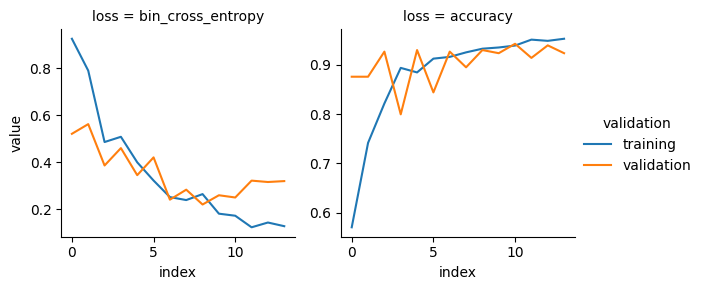

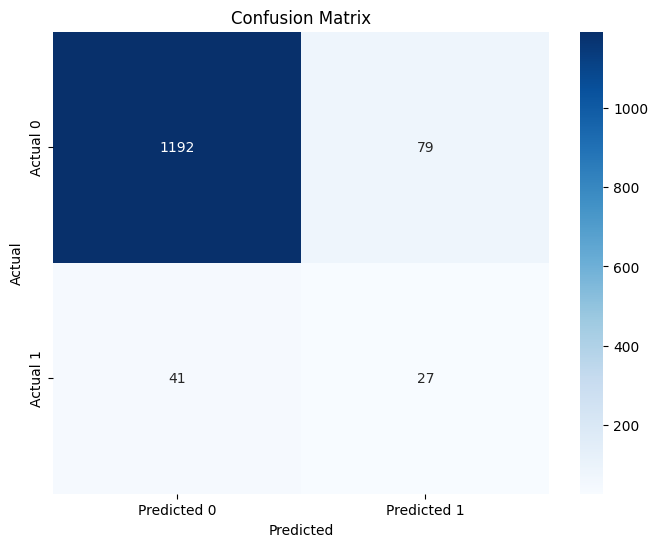

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report


def nn_prepare_seqs(df):
    df = df.filter(reduce(lambda acc, column: acc & (F.size(col(column)) == 22), df.columns[1:-1], F.lit(True)))
    print("Number of records: ", df.count())
    features = df.columns[1:-1]
    print(features)
    label_col = 'label'
    # grouped_data = df.groupBy("fsym_id").agg(F.collect_list(F.array(features)).alias("seq_feats"),
    #                                      F.first(label_col).alias("label"))
    def convert_to_np_array(row):
        seq_feats = row.seq_feats
        label = row.label
        feat_length = len(seq_feats[0])
        date_length = len(seq_feats[0][0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats[0]):
            seq_array[i, :] = np.array(sublist)
        seq_array = seq_array.T
        return (seq_array, label)
    
    # train_seqs_rdd = grouped_data.rdd.map(convert_to_np_array)
    train_df, test_df = t_t_split(df)
    
    # train_seqs = []
    # for stock_id, group in df.groupby('fsym_id'):
    #     seq_feats = group[features]
    #     label = group['label']
    #     feat_length = len(seq_feats.iloc[0])
    #     date_length = len(seq_feats.iloc[0,0])
    #     seq_array = np.zeros((feat_length, date_length))
    #     for i, sublist in enumerate(seq_feats.columns):
    #         seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
    #     seq_array = seq_array.T
    #     train_seqs.append((seq_array, label))
        
        
    # df= df.toPandas()
    # print(df.head())
    # features = df.columns[1:-1]
    # list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
    # df = df.toPandas()
    
    
    
    # for f in features:
    #     df = df.withColumn(f, list_to_vector_udf(f))
    # train_df, test_df = train_test_split(df)
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    
    train_seqs = []
    for stock_id, group in train_df.groupby('fsym_id'):
        seq_feats = group[features]
        label = group['label']
        feat_length = len(seq_feats.iloc[0])
        date_length = len(seq_feats.iloc[0,0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats.columns):
            seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
        seq_array = seq_array.T
        train_seqs.append((seq_array, label))
        
    test_seqs = []
    for stock_id, group in test_df.groupby('fsym_id'):
        seq_feats = group[features]
        label = group['label']
        feat_length = len(seq_feats.iloc[0])
        date_length = len(seq_feats.iloc[0,0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats.columns):
            seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
        seq_array = seq_array.T
        test_seqs.append((seq_array, label))
    
    return train_seqs, test_seqs

def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def nn_training(train_seqs, test_seqs):
    train_X, train_y = zip(*train_seqs)
    test_X, test_y = zip(*test_seqs)

    # Convert lists to numpy arrays
    train_X = np.array(train_X)
    train_y = np.array(train_y)
    test_X = np.array(test_X)
    test_y = np.array(test_y)
    
    class_labels = np.unique(train_y)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=train_y.flatten())
    class_weight_dict = dict(zip(class_labels, class_weights))
    print(class_weight_dict)
    

    # Define the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(train_X.shape[1], train_X.shape[2])),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
        tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
        tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    loss_fn = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(
        learning_rate=0.005
    )

    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # Train the model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    fit_model = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_split=0.1, class_weight = class_weight_dict, callbacks=[early_stopping])
    plot_model_performance(fit_model, 'bin_cross_entropy','accuracy')

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_X, test_y)
    print(f'Test accuracy: {test_acc}')

    # Make predictions on new data
    predictions = model.predict(test_X)
    for i in range(len(predictions)):
        predictions[i] = 1 if predictions[i] >= 0.5 else 0
    print(predictions)
    print(classification_report(predictions, test_y.flatten()))
    
    # pred_df = pd.DataFrame()
    # pred_df['prediction'] = predictions
    # pred_df['label'] = test_y
    # confusion_matrix_pandas(pred_df)
    cm = confusion_matrix(test_y, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# train_seqs, test_seqs = nn_prepare_seqs(df)

nn_training(train_seqs, test_seqs)

In [ ]:
# from tqdm.auto import tqdm

# import torch
# import torch.autograd as autograd
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

# import seaborn as sns
# from pylab import rcParams
# import matplotlib.pyplot as plt
# from matplotlib import rc
# import matplotlib
# from matplotlib.ticker import MaxNLocator

# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split

# from multiprocessing import cpu_count



# class SequenceModel(nn.Module):
#     def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
#         super().__init__()

#         self.lstm = nn.LSTM(
#             input_size = n_features,
#             hidden_size = n_hidden,
#             batch_first = True,
#             num_layers = n_layers, # Stack LSTMs
#             dropout = 0.2  # This model works on a lot of regularisation
#         )

#         self.classifier = nn.Linear(n_hidden, n_classes)

#     def forward(self, x):
#         self.lstm.flatten_parameters()  # For distrubuted training

#         _, (hidden, _) = self.lstm(x)
#         # We want the output from the last layer to go into the final
#         # regressor linear layer
#         out = hidden[-1] 

#         return self.classifier(out)

In [ ]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

def train_tree(train_df):
    rf = RandomForestClassifier(featuresCol='features_vector', labelCol='label', maxDepth=maxDepth, numTrees=numTrees)
    model = rf.fit(train_df)
    preds = model.transform()
    

            
    
    

def train_with_hyperopt(params, df):
    numTrees = int(params['numTrees'])
    maxDepth = int(params['maxDepth'])

    model, f1_score = train_rf(numTrees, maxDepth, df)
    loss = - f1_score
    return {'loss': loss, 'status': STATUS_OK}

def prepare_df():
    df = df.filter(reduce(lambda acc, column: acc & (F.size(col(column)) == 22), df.columns[1:-1], lit(True)))
    print("Number of records: ", df.count())
    features = df.columns[1:-1]
    list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
    for f in features:
        df = df.withColumn(f, list_to_vector_udf(f))
    df.show(2)
    train_df, test_df = train_test_split(df)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)
    return train_df, test_df

# train_df, test_df = prepare_df(df)
# train_with_hyperopt()


In [ ]:
#print(filtered_df.filter(F.col('label')==1).count())

In [ ]:
#df.filter(F.col('label')==1).count()

In [ ]:
# spark.stop()